# Environment initialization

In [1]:
%load_ext autoreload
%autoreload 1
%aimport environment

from environment import CarEnv

import numpy as np

import matplotlib.pyplot as plt

In [2]:
env = CarEnv(0, False)
print(env.observation_space.shape) # size of the image
print(env.action_space) 
action_dim = env.action_space.n

(40, 40, 3)
Discrete(8)


The actions correspond to the following:

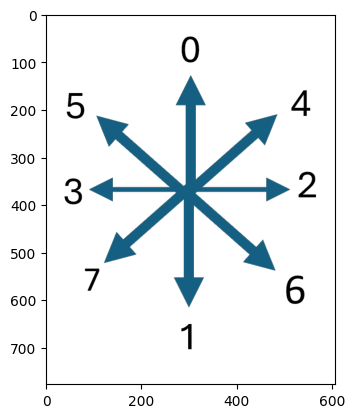

In [3]:
img = plt.imread("action space.png")
plt.imshow(img)

## Test with a random policy

In [4]:
# Create an instance of the custom environment
env = CarEnv(10)

# Example of using the environment
obs = env.reset()
score = 0
while True:
    action = env.action_space.sample()
    obs, reward, done, _ = env.step(action)
    score += reward
    if done:
        break

print('Score:', score)

Score: 4.588358142954642


## Visualization of an observation that will be used by the model

In [5]:
env = CarEnv(10,False)
obs = env.reset()


0.014813194124747332


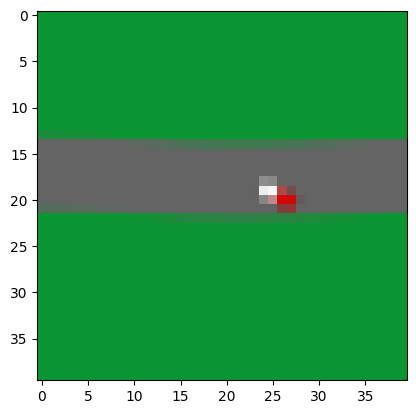

In [6]:
# Size of the image is reduced to make training faster
action = env.action_space.sample()
obs, reward, done, _ = env.step(0)

print(reward)
fig = plt.figure
plt.imshow(obs)

# RL models

In [7]:
import torch
import pandas as pd
import seaborn as sns

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [8]:
from deep_Q_newtork import EpsilonGreedy, MinimumExponentialLR, DQNAgent
from policy import QNetwork, OtherQNetwork
%aimport deep_Q_newtork


c:\Users\matth\AppData\Local\Programs\Python\Python310\lib\site-packages\torchrl\data\replay_buffers\samplers.py:36: UserWarning: Failed to import torchrl C++ binaries. Some modules (eg, prioritized replay buffers) may not work with your installation. If you installed TorchRL from PyPI, please report the bug on TorchRL github. If you installed TorchRL locally and/or in development mode, check that you have all the required compiling packages.
  warnings.warn(EXTENSION_WARNING)


### training loop

In [12]:
env = CarEnv(30, display=False)

loss_fn = torch.nn.MSELoss()

NUMBER_OF_TRAININGS = 1

for train_index in range(NUMBER_OF_TRAININGS):

    # Instantiate required objects

    q_network = QNetwork(action_dim).to(device)
    target_q_network = QNetwork(action_dim).to(device)
    optimizer = torch.optim.AdamW(
        q_network.parameters(), lr=0.004, amsgrad=True)
    epsilon_greedy = EpsilonGreedy(
        epsilon_start=0.9, epsilon_min=0.01, epsilon_decay=0.97, env=env, q_network=q_network)
    # lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.999)
    lr_scheduler = MinimumExponentialLR(
        optimizer, lr_decay=0.99, min_lr=0.0001)

    # Train the q-network
    dqn_agent = DQNAgent(env=env,
                         q_network=q_network,
                         target_q_network=target_q_network,
                         target_q_network_sync_period=100,
                         device=device,
                         gamma=0.9,
                         )

    dqn_agent.train(num_episodes=300,
                    batch_size=128,
                    loss_fn=loss_fn,
                    epsilon_greedy=epsilon_greedy,
                    optimizer=optimizer,
                    lr_scheduler=lr_scheduler,
                    frame_skipping=10,
                    )

# Save the action-value estimation function

torch.save(q_network, "models/DQN2_base_fs10.pth")

  0%|          | 0/299 [00:00<?, ?it/s]

c:\Users\matth\Documents\X\INFautonomous\Projet\environment.py:227: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(obs, dtype=torch.float32).permute(0, 3, 1, 2).to(device)
c:\Users\matth\Documents\X\INFautonomous\Projet\deep_Q_newtork.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch_actions_tensor = torch.tensor(
c:\Users\matth\Documents\X\INFautonomous\Projet\deep_Q_newtork.py:115: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch_rewards_tensor = torch.tensor(
c:\Users\matth\Documents\X\INFautonomous\Proj

Episode 1 - Reward: 8.575981963130719
Episode 2 - Reward: 13.906538565010777
Episode 3 - Reward: -3.7727244370165693
Episode 4 - Reward: 2.63421343811033
Episode 5 - Reward: 0.408152724591024
Episode 6 - Reward: -7.34022089976857
Episode 7 - Reward: 2.703407384986463
Episode 8 - Reward: 14.87740922243154
Episode 9 - Reward: 4.004946008476058
Episode 10 - Reward: 3.6488142090617233
Episode 11 - Reward: 5.786218415253711
Episode 12 - Reward: 2.9267433799338014
Episode 13 - Reward: 3.2128368318239473
Episode 14 - Reward: 6.123144964137163
Episode 15 - Reward: 0.9263086740073381
Episode 16 - Reward: 4.525846152524308
Episode 17 - Reward: 0.21567104363774592
Episode 18 - Reward: 4.399299731578673
Episode 19 - Reward: 2.3295594765571006
Episode 20 - Reward: 2.2988595503925486
Episode 21 - Reward: 4.3250270593990345
Episode 22 - Reward: 2.595309379684371
Episode 23 - Reward: 4.553154331339752
Episode 24 - Reward: 3.3307538266343735
Episode 25 - Reward: 2.499945734774222
Episode 26 - Reward: 5

In [13]:
env.close()

### Results

In [14]:
dqn2_trains_result_df = pd.DataFrame(np.array(dqn_agent.result_list).T, columns=["num_episodes", "mean_final_episode_reward", "training_index"])
dqn2_trains_result_df["agent"] = "DQN 2015"

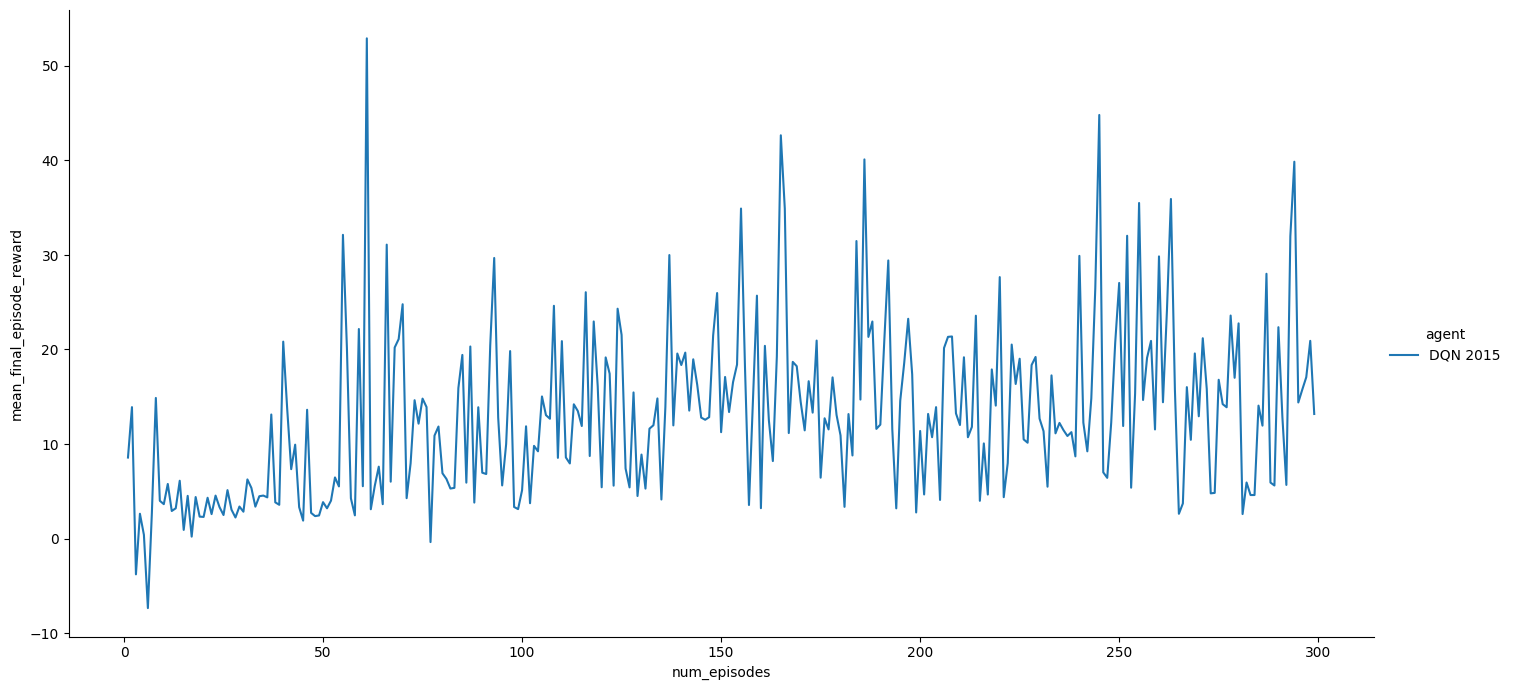

In [15]:
g = sns.relplot(x="num_episodes",
                y="mean_final_episode_reward",
                kind="line",
                hue="agent",
                estimator=None,
                units="training_index",
                data=dqn2_trains_result_df,
                height=7,
                aspect=2)

## Fine-tuning

In [32]:
q_network = torch.load("models/DQN2_FT_fs1.pth", map_location=device)

In [42]:
env = CarEnv(30, display = False)

target_q_network = QNetwork(action_dim).to(device)
optimizer = torch.optim.AdamW(
    q_network.parameters(), lr=0.004, amsgrad=True)
epsilon_greedy = EpsilonGreedy(
    epsilon_start=0.9, epsilon_min=0.01, epsilon_decay=0.97, env=env, q_network=q_network)
# lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.999)
lr_scheduler = MinimumExponentialLR(
    optimizer, lr_decay=0.99, min_lr=0.0001)

# Train the q-network
dqn_agent = DQNAgent(env=env,
                        q_network=q_network,
                        target_q_network=target_q_network,
                        target_q_network_sync_period=100,
                        device=device,
                        gamma=0.9,
                        )

dqn_agent.train(num_episodes=300,
                batch_size=128,
                loss_fn=loss_fn,
                epsilon_greedy=epsilon_greedy,
                optimizer=optimizer,
                lr_scheduler=lr_scheduler,
                frame_skipping=1,
                )

# Save the action-value estimation function

torch.save(q_network, "models/DQN2_FT_fs1.pth")

  0%|          | 0/299 [00:00<?, ?it/s]

c:\Users\matth\Documents\X\INFautonomous\Projet\environment.py:227: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(obs, dtype=torch.float32).permute(0, 3, 1, 2).to(device)
c:\Users\matth\Documents\X\INFautonomous\Projet\deep_Q_newtork.py:113: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch_actions_tensor = torch.tensor(
c:\Users\matth\Documents\X\INFautonomous\Projet\deep_Q_newtork.py:115: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch_rewards_tensor = torch.tensor(
c:\Users\matth\Documents\X\INFautonomous\Proj

Episode 1 - Reward: 23.420423230276572
Episode 2 - Reward: 10.240496620179453
Episode 3 - Reward: 7.36289164682056
Episode 4 - Reward: 5.888923714589707
Episode 5 - Reward: 8.652680646363685
Episode 6 - Reward: 3.433530629584887
Episode 7 - Reward: 4.383114161971668
Episode 8 - Reward: 6.085307780433748
Episode 9 - Reward: 3.553989663693615
Episode 10 - Reward: 4.3392355167954655
Episode 11 - Reward: 10.8947882205457
Episode 12 - Reward: 9.849979352911514
Episode 13 - Reward: 11.474421496403508
Episode 14 - Reward: 10.272355678705718
Episode 15 - Reward: 3.444258957862395
Episode 16 - Reward: 14.948487484772217
Episode 17 - Reward: 5.702187355926983
Episode 18 - Reward: 6.129587803062957
Episode 19 - Reward: -0.0726419609683424
Episode 20 - Reward: 3.816170906907715
Episode 21 - Reward: 2.5188429268769648
Episode 22 - Reward: 5.014981352383944
Episode 23 - Reward: 3.100955028574676
Episode 24 - Reward: 4.486161774324847
Episode 25 - Reward: 2.662255574789681
Episode 26 - Reward: 6.6377

### Results

In [43]:
dqn2_trains_result_df = pd.DataFrame(np.array(dqn_agent.result_list).T, columns=["num_episodes", "mean_final_episode_reward", "training_index"])
dqn2_trains_result_df["agent"] = "DQN 2015"

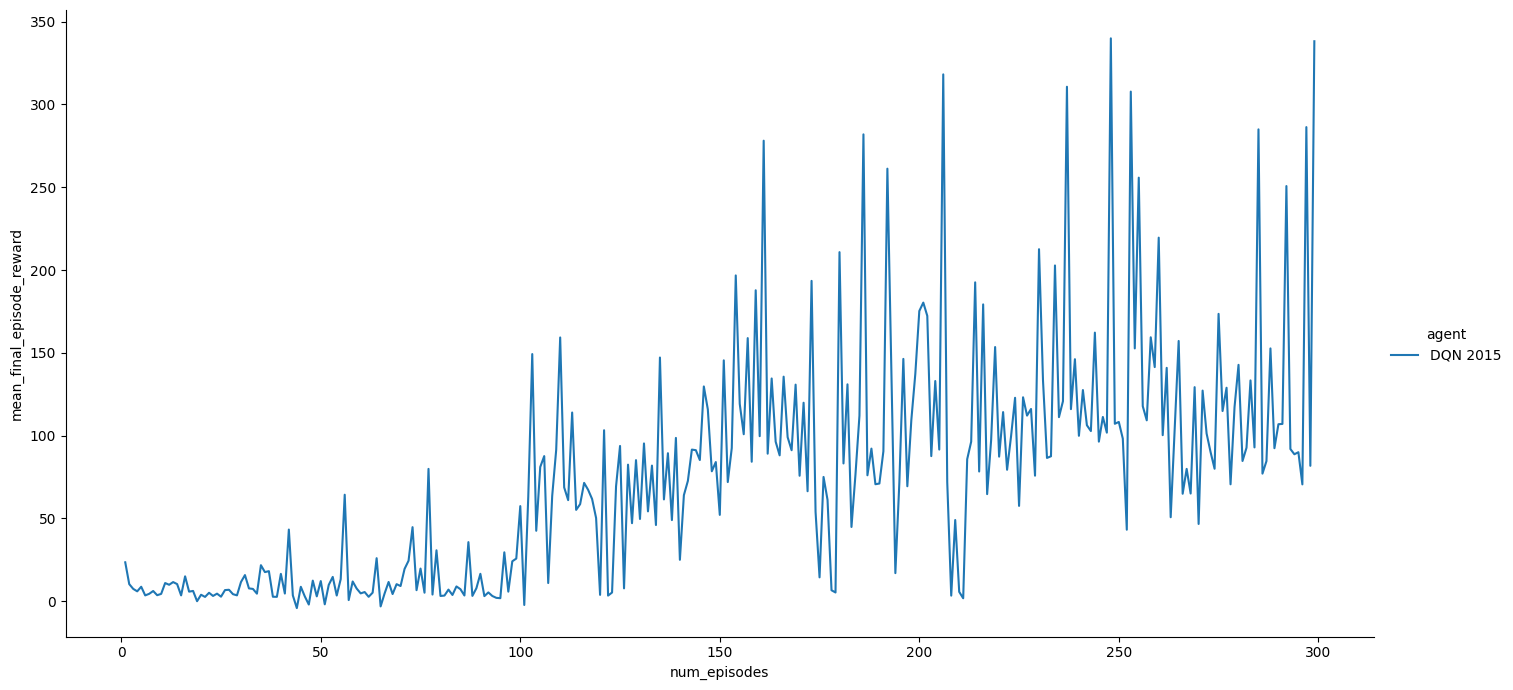

In [44]:
g = sns.relplot(x="num_episodes",
                y="mean_final_episode_reward",
                kind="line",
                hue="agent",
                estimator=None,
                units="training_index",
                data=dqn2_trains_result_df,
                height=7,
                aspect=2)

# Run the game with a trained model

The model can be loaded from the `models` folder

In [8]:
import pygame as pg
import torch
from deep_Q_newtork import EpsilonGreedy, MinimumExponentialLR, DQNAgent
from policy import QNetwork, OtherQNetwork
from environment import CarEnv

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [67]:


q_network = torch.load("models\CEM.pth", map_location=device) # Choose the model here
modelisverygood = False


test_size = 10

s=0
env = CarEnv(30,display=True, evaluation=True, draw_central_line=True)
obs = env.reset()

while True:
    obstensor = CarEnv.obs2tensor(obs, device)

    action = q_network(obstensor).argmax(dim=1)
    if modelisverygood: # the VG models come from an older implementation with a smaller action space (they could only go right and left by moving forward), hence this adjustment
        if action==2: action=4
        elif action==3: action=5
    obs, reward, done, _ = env.step(action)
    s += reward
    if done:
        break

env.close()

print("Score :" + str(s))

Score :102.78238569025156


### Scores

In [71]:


q_network = torch.load("models\VG.pth", map_location=device) # Choose the model here
modelisverygood = True
randompolicy = False
alwaysforwardpolicy = False

# Create an instance of the custom environment

# Example of using the environment

score = []

test_size = 10

for i in range(test_size):
    s=0
    env = CarEnv(30,display=False, evaluation=True, draw_central_line=False)
    obs = env.reset()
    while True:
        obstensor = CarEnv.obs2tensor(obs, device)
        if randompolicy:
            action = env.action_space.sample()
        elif alwaysforwardpolicy:
            action = 0
        else:
            action = q_network(obstensor).argmax(dim=1)
            if modelisverygood: # the VG models come from an older implementation with a smaller action space (they could only go right and left by moving forward), hence this adjustment
                if action==2: action=4
                elif action==3: action=5
        obs, reward, done, _ = env.step(action)
        s += reward
        if done:
            break
    score.append(s)
    env.close()

print("Score :" + str(sum(score)/len(score)))

Score :163.4470204763402
